In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from pclib.utils.customdataset import PreloadedDataset
import os
import matplotlib.pyplot as plt
%matplotlib inline  
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [2]:
seed = 42
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(seed)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)

INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

In [32]:
def test(
    model,
    criterion,
    test_loader,
):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)
            output = model(data)
            test_loss += criterion(output, data).item()

    test_loss /= len(test_loader.dataset)
    return test_loss

def train(
    model,
    model_name,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=10,
    device=device,
    step=0,
    track=False,
):
    if track:
        writer = SummaryWriter(f"examples/mnist/logs/autoencoder/{model_name}")
    train_losses = []
    val_losses = []

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, verbose=True)

    for epoch in range(num_epochs):
        epoch_loss = 0
        train_dataset.apply_transform()
        model.train()

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        for batch_idx, (data, target) in loop:
            data = data.view(-1, 784).to(device)
            optimiser.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            epoch_loss += loss.item()
            loss.backward()
            optimiser.step()
            if batch_idx == 0:

                torch.save(model.state_dict(), f"{model_name}.pth")
                val_loss = test(model, criterion, val_loader)
                model.train()

            #  TQDM bar update
            if epoch > 0 and batch_idx > 0:
                loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
                loop.set_postfix(
                    train_loss = train_losses[-1],
                    val_loss = val_losses[-1], 
                )

        train_losses.append(epoch_loss / len(train_loader.dataset))
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        step += 1
            
        if track:
            writer.add_scalar("Loss/train", train_losses[-1], step)
            writer.add_scalar("Loss/val", val_losses[-1], step)
    return train_losses, val_losses, step

In [38]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, bias=True):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(INPUT_SHAPE, 200, bias=bias),
            nn.Linear(200, 128, bias=bias),
            nn.Linear(128, 200, bias=bias),
            nn.Linear(200, INPUT_SHAPE, bias=bias),
        ])
        self.actv_fn = F.relu
    
    def train(self, mode=True):
        self.actv_fn = lambda x: x * (x > 0.2).float()
        # self.actv_fn = F.relu
    
    def eval(self):
        self.actv_fn = F.relu
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.actv_fn(x)
            else:
                x = torch.sigmoid(x)
        return x

In [39]:
torch.manual_seed(seed)

model_name = f"same_arch_zae0.2-nobias"
model = AutoEncoder(bias=False).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
step = 0

In [40]:
NUM_EPOCHS = 50
BATCH_SIZE = 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_losses, val_losses, step = train(
    model,
    model_name,
    optimiser,
    criterion,
    train_loader,
    val_loader,
    num_epochs=NUM_EPOCHS,
    device=device,
    step=step,
    track=True,
)

min val loss: 0.0048512300203243895
min train loss: 0.004952254397173722


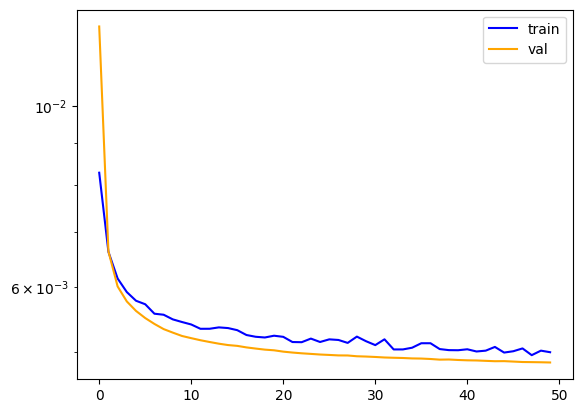

In [25]:
# plot em all
print("min val loss:", min(val_losses))
print("min train loss:", min(train_losses))
plt.plot(train_losses, label="train", color="blue")
plt.plot(val_losses, label="val", color="orange")
plt.legend()
plt.yscale("log")
plt.show()